# CNN on the Fashion-MNIST dataset using Pytorch 

In [47]:
import sys, os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim import *
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.nn import *
from torch.autograd import Variable
from torchsummary import summary 
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import fashion_mnist

# Step 1 : Load, visualize & pre-process the MNIST dataset 

In [48]:
#Load the data, add it into RAM and create proper train, test and val splits

os.system('curl -fsS http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -o /tmp/train-images-idx3-ubyte.gz')
os.system('curl -fsS http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -o /tmp/train-labels-idx1-ubyte.gz')
os.system('curl -fsS http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -o /tmp/t10k-images-idx3-ubyte.gz')
os.system('curl -fsS http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -o /tmp/t10k-labels-idx1-ubyte.gz')

(trainxs, trainys), (testxs, testys) = fashion_mnist.load_data()

input_size = testxs.shape[1] ** 2

y_train = trainys[:50000]
X_train = trainxs[:50000]
y_val = trainys[50001:]
X_val = trainxs[50001:]
X_test = testxs
y_test = testys

categories=['Shirt','Pants','L.S. shirt','Dress','Jacket','Heel','Blouse','Sneaker','Purse','Boot'] #10 classes 

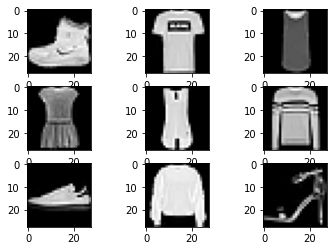

In [49]:
#Plot first few images of the training set

for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [50]:
#Reshape xs

X_train=X_train.reshape(X_train.shape[0],1,28,28)
X_val=X_val.reshape(X_val.shape[0],1,28,28)
X_test=X_test.reshape(X_test.shape[0],1,28,28)

In [51]:
# Creates train and validation data for Dataloader

traindata = []
for i in range(len(X_train)):
    traindata.append([X_train[i], y_train[i]])
    
valdata=[]
for i in range(len(X_val)):
    valdata.append([X_val[i],y_val[i]])
    
testdata=[]
for i in range(len(X_test)):
    testdata.append([X_test[i],y_test[i]])

# Step 2 : Create the CNN

In [52]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        #3 convolutional layers 
        self.conv1=nn.Conv2d(1,16,2,padding=(1,1))
        self.conv2=nn.Conv2d(16,32,2,padding=(1,1))
        self.conv3=nn.Conv2d(32,64,2,padding=(1,1))
        
        #Dropouts regularisation technique to avoid overfitting
        self.dropout=nn.Dropout(p=0.5)
        
        #3 mlp layers 
        self.fc1=nn.Linear(1024,800)
        self.fc2=nn.Linear(800,32)
        self.fc3=nn.Linear(32,10) #outputs 10 classes 
        
        self.softmax=nn.Softmax(dim=1)

    def forward(self,x):
        x=F.max_pool2d(F.relu(self.conv1(x)),2)
        x=F.max_pool2d(F.relu(self.conv2(x)),2)
        x=F.max_pool2d(F.relu(self.conv3(x)),2)

        x=x.view(x.size(0),-1)
        x=self.dropout(x)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))

        return x

In [53]:
print(summary(CNN(), (1, 28, 28 )))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 29, 29]              80
            Conv2d-2           [-1, 32, 15, 15]           2,080
            Conv2d-3             [-1, 64, 8, 8]           8,256
           Dropout-4                 [-1, 1024]               0
            Linear-5                  [-1, 800]         820,000
            Linear-6                   [-1, 32]          25,632
            Linear-7                   [-1, 10]             330
Total params: 856,378
Trainable params: 856,378
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 3.27
Estimated Total Size (MB): 3.47
----------------------------------------------------------------
None


# Step 3 : Train & evaluate the model

In [54]:
def train(learning_rate, epochs, traindata, valdata, model, device, batch, wd):
    
    train_acc=[]
    train_err=[]
    val_acc=[]
    val_err=[]
    
    trainloader=torch.utils.data.DataLoader(traindata,batch_size=batch,shuffle=True)
    
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(model.parameters(),lr=learning_rate, weight_decay = wd)
    
    for epoch in tqdm(range(0,epochs)):
        
        current_loss=0.0
        
        correct=0
        total=0
        
        for i,data in tqdm(enumerate(trainloader,0)):
            
            input,label=data[0].to(device),data[1].to(device)
            optimizer.zero_grad()
            output=model(input.float())
            _,predicted=torch.max(output.data,1)
            
            total+=label.size(0)
            correct+=(predicted==label).sum().item()
            loss=criterion(output,label.long())
            loss.backward()
            optimizer.step()
              
            current_loss+=loss.item()

        # Prints loss and accuracy for each epoch
        print('Epoch : ',epoch)
        print('Train loss : ', current_loss / (i+1))
        print( '')
        
        train_acc.append(100*correct/total)
        train_err.append(current_loss/(i+1))
        va,ve=validation(valdata,batch,model,device)
        val_acc.append(va)
        val_err.append(ve)
        
    return train_acc,train_err,val_acc,val_err

In [55]:
def validation (valdata,batch,model,device):
    valloader=torch.utils.data.DataLoader(valdata,batch_size=batch,shuffle=True)
    criterion=nn.CrossEntropyLoss()
    correct=0
    total=0
    current_loss=0
    i=0
    with torch.no_grad():
        for data in valloader:
            input,label=data[0].to(device),data[1].to(device)
            output=model(input.float())
            _,predicted=torch.max(output.data,1)
            total+=label.size(0)
            correct+=(predicted==label).sum().item()
            loss=criterion(output,label.long())
            current_loss+=loss.item()
            i+=1
    print("Validation Accuracy: ", (100*correct/total),"%")
    
    return (100*correct/total), current_loss/(i)

In [56]:
torch.manual_seed(0)
torch.set_deterministic(True)
batch=128
learning_rate=0.0001
wd = 0.01
epochs = 300
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
CNN=CNN()
CNN.to(device)
train_acc,train_err,val_acc,val_err = train(learning_rate,epochs,traindata,valdata,CNN,device,batch, wd)


Epoch :  0
Train loss :  1.0700038669969114

Validation Accuracy:  71.83718371837183 %



Epoch :  1
Train loss :  0.8514253629747864

Validation Accuracy:  72.97729772977297 %



Epoch :  2
Train loss :  0.8087737028251218

Validation Accuracy:  73.30733073307331 %



Epoch :  3
Train loss :  0.7834658754603637

Validation Accuracy:  73.88738873887388 %



Epoch :  4
Train loss :  0.770150897829124

Validation Accuracy:  74.03740374037403 %



Epoch :  5
Train loss :  0.7625019583860626

Validation Accuracy:  74.45744574457446 %



Epoch :  6
Train loss :  0.7511525236432205

Validation Accuracy:  74.51745174517451 %



Epoch :  7
Train loss :  0.7477446898170139

Validation Accuracy:  74.86748674867486 %



Epoch :  8
Train loss :  0.7415010438245886

Validation Accuracy:  75.02750275027503 %



Epoch :  9
Train loss :  0.7365385440304456

Validation Accuracy:  74.71747174717471 %



Epoch :  10
Train loss :  0.7316451480474009

Validation Accuracy:  75.22752275227523 %



Epoch :  11
Train loss :  0.7273979336404435

Validation Accuracy:  74.94749474947494 %



Epoch :  12
Train loss :  0.725390033953635

Validation Accuracy:  75.40754075407541 %



Epoch :  13
Train loss :  0.7224583321672571

Validation Accuracy:  75.02750275027503 %



Epoch :  14
Train loss :  0.7176716799473823

Validation Accuracy:  75.23752375237524 %



Epoch :  15
Train loss :  0.7159668871813722

Validation Accuracy:  75.11751175117512 %



Epoch :  16
Train loss :  0.7137952539164697

Validation Accuracy:  75.21752175217522 %



Epoch :  17
Train loss :  0.7087936083526563

Validation Accuracy:  75.06750675067507 %



Epoch :  18
Train loss :  0.706919239762494

Validation Accuracy:  75.2975297529753 %



Epoch :  19
Train loss :  0.7049243280954678

Validation Accuracy:  75.13751375137514 %



Epoch :  20
Train loss :  0.7069161775929239

Validation Accuracy:  74.91749174917491 %



Epoch :  21
Train loss :  0.7011632460462468

Validation Accuracy:  75.43754375437544 %



Epoch :  22
Train loss :  0.6985073357896732

Validation Accuracy:  75.53755375537554 %



Epoch :  23
Train loss :  0.6963574697294503

Validation Accuracy:  75.87758775877587 %



Epoch :  24
Train loss :  0.6454278578233841

Validation Accuracy:  83.2983298329833 %



Epoch :  25
Train loss :  0.5509596914434067

Validation Accuracy:  83.4983498349835 %



Epoch :  26
Train loss :  0.5334753335436897

Validation Accuracy:  82.97829782978297 %



Epoch :  27
Train loss :  0.5264884892784422

Validation Accuracy:  83.2983298329833 %



Epoch :  28
Train loss :  0.5227718360893562

Validation Accuracy:  83.71837183718372 %



Epoch :  29
Train loss :  0.5180638520156636

Validation Accuracy:  83.3883388338834 %



Epoch :  30
Train loss :  0.5123660298412108

Validation Accuracy:  83.63836383638363 %



Epoch :  31
Train loss :  0.51069908472888

Validation Accuracy:  83.74837483748375 %



Epoch :  32
Train loss :  0.5094386405499695

Validation Accuracy:  84.07840784078408 %



Epoch :  33
Train loss :  0.5073689790180577

Validation Accuracy:  83.4083408340834 %



Epoch :  34
Train loss :  0.5049810834095606

Validation Accuracy:  83.57835783578358 %



Epoch :  35
Train loss :  0.5012285292834577

Validation Accuracy:  83.68836883688368 %



Epoch :  36
Train loss :  0.49970260757924345

Validation Accuracy:  83.64836483648365 %



Epoch :  37
Train loss :  0.49931037140166973

Validation Accuracy:  83.92839283928393 %



Epoch :  38
Train loss :  0.3407022915685268

Validation Accuracy:  88.15881588158815 %



Epoch :  39
Train loss :  0.29595250939316764

Validation Accuracy:  88.45884588458846 %



Epoch :  40
Train loss :  0.2902022779292768

Validation Accuracy:  88.42884288428843 %



Epoch :  41
Train loss :  0.28830704657013156

Validation Accuracy:  88.55885588558856 %



Epoch :  42
Train loss :  0.2848777581206368

Validation Accuracy:  88.97889788978898 %



Epoch :  43
Train loss :  0.28704388809326054

Validation Accuracy:  88.90889088908891 %



Epoch :  44
Train loss :  0.28281996103808704

Validation Accuracy:  89.18891889188919 %



Epoch :  45
Train loss :  0.28247165489379705

Validation Accuracy:  89.04890489048906 %



Epoch :  46
Train loss :  0.2783118999370224

Validation Accuracy:  88.94889488948895 %



Epoch :  47
Train loss :  0.27843388897912275

Validation Accuracy:  89.63896389638964 %



Epoch :  48
Train loss :  0.2750572763821658

Validation Accuracy:  89.16891689168916 %



Epoch :  49
Train loss :  0.275116095609982

Validation Accuracy:  88.6988698869887 %



Epoch :  50
Train loss :  0.27290656099386534

Validation Accuracy:  89.24892489248924 %



Epoch :  51
Train loss :  0.2704895025552691

Validation Accuracy:  88.87888788878888 %



Epoch :  52
Train loss :  0.2714155970136528

Validation Accuracy:  89.23892389238924 %



Epoch :  53
Train loss :  0.26897178346391226

Validation Accuracy:  88.87888788878888 %



Epoch :  54
Train loss :  0.26830568303689933

Validation Accuracy:  89.30893089308931 %



Epoch :  55
Train loss :  0.2693893153344274

Validation Accuracy:  89.38893889388939 %



Epoch :  56
Train loss :  0.26460680266475434

Validation Accuracy:  89.55895589558956 %



Epoch :  57
Train loss :  0.26632450423810794

Validation Accuracy:  89.03890389038904 %



Epoch :  58
Train loss :  0.264782854891799

Validation Accuracy:  89.18891889188919 %



Epoch :  59
Train loss :  0.2641172935933713

Validation Accuracy:  89.30893089308931 %



Epoch :  60
Train loss :  0.2605770655605189

Validation Accuracy:  89.22892289228923 %



Epoch :  61
Train loss :  0.25998090680145547

Validation Accuracy:  89.5989598959896 %



Epoch :  62
Train loss :  0.2629228745732466

Validation Accuracy:  89.06890689068906 %



Epoch :  63
Train loss :  0.260642492214737

Validation Accuracy:  89.38893889388939 %



Epoch :  64
Train loss :  0.25719961005708447

Validation Accuracy:  89.34893489348934 %



Epoch :  65
Train loss :  0.25971360657068776

Validation Accuracy:  89.34893489348934 %



Epoch :  66
Train loss :  0.2577332441535447

Validation Accuracy:  89.31893189318932 %



Epoch :  67
Train loss :  0.2569182720749884

Validation Accuracy:  89.73897389738974 %



Epoch :  68
Train loss :  0.25804751295872663

Validation Accuracy:  89.44894489448944 %



Epoch :  69
Train loss :  0.25507484311642853

Validation Accuracy:  89.56895689568957 %



Epoch :  70
Train loss :  0.25287661794811256

Validation Accuracy:  89.40894089408941 %



Epoch :  71
Train loss :  0.2547354032773801

Validation Accuracy:  89.48894889488949 %



Epoch :  72
Train loss :  0.25241328699661947

Validation Accuracy:  89.62896289628964 %



Epoch :  73
Train loss :  0.25170905007730665

Validation Accuracy:  89.74897489748975 %



Epoch :  74
Train loss :  0.2500446560742605

Validation Accuracy:  89.71897189718972 %



Epoch :  75
Train loss :  0.2529913638253956

Validation Accuracy:  89.54895489548954 %



Epoch :  76
Train loss :  0.24920035311785502

Validation Accuracy:  89.85898589858986 %



Epoch :  77
Train loss :  0.2499372792975677

Validation Accuracy:  89.58895889588959 %



Epoch :  78
Train loss :  0.25167811511422666

Validation Accuracy:  89.56895689568957 %



Epoch :  79
Train loss :  0.24878668506889393

Validation Accuracy:  89.58895889588959 %



Epoch :  80
Train loss :  0.25037651709126085

Validation Accuracy:  89.77897789778977 %



Epoch :  81
Train loss :  0.2469626500478486

Validation Accuracy:  89.70897089708971 %



Epoch :  82
Train loss :  0.24640817383823493

Validation Accuracy:  89.75897589758976 %



Epoch :  83
Train loss :  0.2471781858931417

Validation Accuracy:  89.62896289628964 %



Epoch :  84
Train loss :  0.24596519604363404

Validation Accuracy:  89.75897589758976 %



Epoch :  85
Train loss :  0.24673221936768583

Validation Accuracy:  89.55895589558956 %



Epoch :  86
Train loss :  0.24505044203585066

Validation Accuracy:  89.75897589758976 %



Epoch :  87
Train loss :  0.24402607369529622

Validation Accuracy:  89.91899189918992 %



Epoch :  88
Train loss :  0.24632514052836182

Validation Accuracy:  90.26902690269027 %



Epoch :  89
Train loss :  0.2427383777316269

Validation Accuracy:  89.53895389538954 %



Epoch :  90
Train loss :  0.24392647639183743

Validation Accuracy:  89.97899789978997 %



Epoch :  91
Train loss :  0.2443692077265676

Validation Accuracy:  89.93899389938994 %



Epoch :  92
Train loss :  0.24312287447092784

Validation Accuracy:  89.70897089708971 %



Epoch :  93
Train loss :  0.2441930391294572

Validation Accuracy:  89.94899489948995 %



Epoch :  94
Train loss :  0.24146465377886886

Validation Accuracy:  90.35903590359035 %



Epoch :  95
Train loss :  0.24181169745943432

Validation Accuracy:  89.88898889888989 %



Epoch :  96
Train loss :  0.24098093426593428

Validation Accuracy:  89.42894289428943 %



Epoch :  97
Train loss :  0.23943828913333165

Validation Accuracy:  89.75897589758976 %



Epoch :  98
Train loss :  0.23991040965480268

Validation Accuracy:  89.95899589958997 %



Epoch :  99
Train loss :  0.24015578193127957

Validation Accuracy:  89.81898189818982 %



Epoch :  100
Train loss :  0.2373388910766148

Validation Accuracy:  89.82898289828982 %



Epoch :  101
Train loss :  0.23890328900817107

Validation Accuracy:  89.92899289928992 %



Epoch :  102
Train loss :  0.23804194663110598

Validation Accuracy:  90.16901690169017 %



Epoch :  103
Train loss :  0.23712933879069356

Validation Accuracy:  90.1890189018902 %



Epoch :  104
Train loss :  0.2377218471273132

Validation Accuracy:  89.81898189818982 %



Epoch :  105
Train loss :  0.23568798565422483

Validation Accuracy:  90.46904690469047 %



Epoch :  106
Train loss :  0.23850118631825729

Validation Accuracy:  89.86898689868987 %



Epoch :  107
Train loss :  0.23859896040176187

Validation Accuracy:  90.06900690069007 %



Epoch :  108
Train loss :  0.23466932948897867

Validation Accuracy:  90.42904290429043 %



Epoch :  109
Train loss :  0.23714109197678163

Validation Accuracy:  89.98899889988999 %



Epoch :  110
Train loss :  0.23431517947893923

Validation Accuracy:  90.12901290129012 %



Epoch :  111
Train loss :  0.23333030296942156

Validation Accuracy:  89.96899689968997 %



Epoch :  112
Train loss :  0.2345089316177551

Validation Accuracy:  90.07900790079007 %



Epoch :  113
Train loss :  0.23384207969202714

Validation Accuracy:  90.05900590059007 %



Epoch :  114
Train loss :  0.23297754227352874

Validation Accuracy:  90.2890289028903 %



Epoch :  115
Train loss :  0.23351292420759837

Validation Accuracy:  90.06900690069007 %



Epoch :  116
Train loss :  0.2309676240510343

Validation Accuracy:  89.96899689968997 %



Epoch :  117
Train loss :  0.23119763854671926

Validation Accuracy:  89.92899289928992 %



Epoch :  118
Train loss :  0.2317472565585695

Validation Accuracy:  89.75897589758976 %



Epoch :  119
Train loss :  0.22990188067374023

Validation Accuracy:  89.6989698969897 %



Epoch :  120
Train loss :  0.23332252886975208

Validation Accuracy:  90.00900090009002 %



Epoch :  121
Train loss :  0.23198662810694531

Validation Accuracy:  90.01900190019002 %



Epoch :  122
Train loss :  0.23152390446351923

Validation Accuracy:  89.99899989999 %



Epoch :  123
Train loss :  0.2310135773075816

Validation Accuracy:  90.04900490049005 %



Epoch :  124
Train loss :  0.22949269715020115

Validation Accuracy:  90.2090209020902 %



Epoch :  125
Train loss :  0.2311589958722634

Validation Accuracy:  90.46904690469047 %



Epoch :  126
Train loss :  0.23061264350133784

Validation Accuracy:  90.1890189018902 %



Epoch :  127
Train loss :  0.23153506244158806

Validation Accuracy:  90.04900490049005 %



Epoch :  128
Train loss :  0.23048248589801057

Validation Accuracy:  89.93899389938994 %



Epoch :  129
Train loss :  0.23073950865308343

Validation Accuracy:  90.34903490349035 %



Epoch :  130
Train loss :  0.22871750158727017

Validation Accuracy:  89.87898789878987 %



Epoch :  131
Train loss :  0.22916199895731934

Validation Accuracy:  90.24902490249025 %



Epoch :  132
Train loss :  0.2295100137095927

Validation Accuracy:  90.1990199019902 %



Epoch :  133
Train loss :  0.22805153271731207

Validation Accuracy:  90.13901390139014 %



Epoch :  134
Train loss :  0.22964821599633492

Validation Accuracy:  90.13901390139014 %



Epoch :  135
Train loss :  0.22831733896375617

Validation Accuracy:  89.84898489848985 %



Epoch :  136
Train loss :  0.2264613610932894

Validation Accuracy:  89.33893389338934 %



Epoch :  137
Train loss :  0.22782987664880044

Validation Accuracy:  89.93899389938994 %



Epoch :  138
Train loss :  0.2271123267233829

Validation Accuracy:  89.84898489848985 %



Epoch :  139
Train loss :  0.22618077683936605

Validation Accuracy:  89.97899789978997 %



Epoch :  140
Train loss :  0.22505955975455091

Validation Accuracy:  89.75897589758976 %



Epoch :  141
Train loss :  0.22648987783800306

Validation Accuracy:  90.10901090109012 %



Epoch :  142
Train loss :  0.22703264499335643

Validation Accuracy:  90.17901790179017 %



Epoch :  143
Train loss :  0.2256550607664506

Validation Accuracy:  89.96899689968997 %



Epoch :  144
Train loss :  0.22753465686307844

Validation Accuracy:  90.26902690269027 %



Epoch :  145
Train loss :  0.22580889465711307

Validation Accuracy:  90.52905290529053 %



Epoch :  146
Train loss :  0.22572284706337067

Validation Accuracy:  89.74897489748975 %



Epoch :  147
Train loss :  0.22671959152840593

Validation Accuracy:  90.3890389038904 %



Epoch :  148
Train loss :  0.22303679857946113

Validation Accuracy:  90.04900490049005 %



Epoch :  149
Train loss :  0.22348113956353854

Validation Accuracy:  90.06900690069007 %



Epoch :  150
Train loss :  0.22128258818936775

Validation Accuracy:  90.35903590359035 %



Epoch :  151
Train loss :  0.22533414852055136

Validation Accuracy:  90.02900290029002 %



Epoch :  152
Train loss :  0.22426032635104626

Validation Accuracy:  90.23902390239024 %



Epoch :  153
Train loss :  0.2230750345398703

Validation Accuracy:  90.4090409040904 %



Epoch :  154
Train loss :  0.22317825057698637

Validation Accuracy:  90.47904790479048 %



Epoch :  155
Train loss :  0.22359503710361392

Validation Accuracy:  90.14901490149015 %



Epoch :  156
Train loss :  0.22292537560395878

Validation Accuracy:  90.00900090009002 %



Epoch :  157
Train loss :  0.22267354380749071

Validation Accuracy:  89.95899589958997 %



Epoch :  158
Train loss :  0.2220393513779506

Validation Accuracy:  90.45904590459045 %



Epoch :  159
Train loss :  0.22255136914875195

Validation Accuracy:  90.13901390139014 %



Epoch :  160
Train loss :  0.22166779568738035

Validation Accuracy:  89.97899789978997 %



Epoch :  161
Train loss :  0.22440825488485033

Validation Accuracy:  90.10901090109012 %



Epoch :  162
Train loss :  0.2194947202301696

Validation Accuracy:  90.15901590159015 %



Epoch :  163
Train loss :  0.2235923037314049

Validation Accuracy:  89.7989798979898 %



Epoch :  164
Train loss :  0.22342268390881131

Validation Accuracy:  90.35903590359035 %



Epoch :  165
Train loss :  0.22209278772325466

Validation Accuracy:  90.23902390239024 %



Epoch :  166
Train loss :  0.21962370925470995

Validation Accuracy:  90.51905190519052 %



Epoch :  167
Train loss :  0.22142289382646152

Validation Accuracy:  89.90899089908991 %



Epoch :  168
Train loss :  0.22279788469871903

Validation Accuracy:  90.33903390339034 %



Epoch :  169
Train loss :  0.221683295067314

Validation Accuracy:  90.4890489048905 %



Epoch :  170
Train loss :  0.22066388782256705

Validation Accuracy:  90.24902490249025 %



Epoch :  171
Train loss :  0.2205153332303857

Validation Accuracy:  90.10901090109012 %



Epoch :  172
Train loss :  0.21941018958225886

Validation Accuracy:  90.13901390139014 %



Epoch :  173
Train loss :  0.22145433531469091

Validation Accuracy:  90.00900090009002 %



Epoch :  174
Train loss :  0.21841815235974538

Validation Accuracy:  90.10901090109012 %



Epoch :  175
Train loss :  0.21851756938201997

Validation Accuracy:  89.87898789878987 %



Epoch :  176
Train loss :  0.22181088477373123

Validation Accuracy:  90.10901090109012 %



Epoch :  177
Train loss :  0.22141094014162907

Validation Accuracy:  90.31903190319032 %



Epoch :  178
Train loss :  0.21922225093521425

Validation Accuracy:  90.42904290429043 %



Epoch :  179
Train loss :  0.21699349283028746

Validation Accuracy:  90.2890289028903 %



Epoch :  180
Train loss :  0.2189013946353627

Validation Accuracy:  90.6090609060906 %



Epoch :  181
Train loss :  0.21928247750338997

Validation Accuracy:  90.1890189018902 %



Epoch :  182
Train loss :  0.21946518584285551

Validation Accuracy:  90.05900590059007 %



Epoch :  183
Train loss :  0.21932411367249915

Validation Accuracy:  90.0990099009901 %



Epoch :  184
Train loss :  0.21944979780241655

Validation Accuracy:  89.98899889988999 %



Epoch :  185
Train loss :  0.21943008781546522

Validation Accuracy:  90.05900590059007 %



Epoch :  186
Train loss :  0.21853243660591448

Validation Accuracy:  90.05900590059007 %



Epoch :  187
Train loss :  0.21698703736905248

Validation Accuracy:  90.5890589058906 %



Epoch :  188
Train loss :  0.21835376186977568

Validation Accuracy:  90.0990099009901 %



Epoch :  189
Train loss :  0.21609621207275048

Validation Accuracy:  90.36903690369037 %



Epoch :  190
Train loss :  0.21646607326119757

Validation Accuracy:  90.35903590359035 %



Epoch :  191
Train loss :  0.2172251721401044

Validation Accuracy:  90.27902790279028 %



Epoch :  192
Train loss :  0.21690396831163664

Validation Accuracy:  90.32903290329033 %



Epoch :  193
Train loss :  0.21655076633557638

Validation Accuracy:  90.22902290229023 %



Epoch :  194
Train loss :  0.2168285729330214

Validation Accuracy:  90.15901590159015 %



Epoch :  195
Train loss :  0.2170458785484514

Validation Accuracy:  90.87908790879088 %



Epoch :  196
Train loss :  0.2185754321915719

Validation Accuracy:  90.47904790479048 %



Epoch :  197
Train loss :  0.21629039390617624

Validation Accuracy:  90.11901190119012 %



Epoch :  198
Train loss :  0.21729471073354906

Validation Accuracy:  90.54905490549055 %



Epoch :  199
Train loss :  0.2145519702102217

Validation Accuracy:  90.06900690069007 %



Epoch :  200
Train loss :  0.21788862778250215

Validation Accuracy:  90.2890289028903 %



Epoch :  201
Train loss :  0.21675715060032846

Validation Accuracy:  90.37903790379038 %



Epoch :  202
Train loss :  0.21709682697149188

Validation Accuracy:  90.47904790479048 %



Epoch :  203
Train loss :  0.21312054824036405

Validation Accuracy:  90.26902690269027 %



Epoch :  204
Train loss :  0.21788178353815738

Validation Accuracy:  90.24902490249025 %



Epoch :  205
Train loss :  0.21300680872500705

Validation Accuracy:  90.3090309030903 %



Epoch :  206
Train loss :  0.2165103045761433

Validation Accuracy:  90.3990399039904 %



Epoch :  207
Train loss :  0.21317740605996394

Validation Accuracy:  90.51905190519052 %



Epoch :  208
Train loss :  0.21548639706638464

Validation Accuracy:  90.15901590159015 %



Epoch :  209
Train loss :  0.21556145631138932

Validation Accuracy:  90.31903190319032 %



Epoch :  210
Train loss :  0.21522683198647122

Validation Accuracy:  90.21902190219022 %



Epoch :  211
Train loss :  0.21325235352720445

Validation Accuracy:  89.97899789978997 %



Epoch :  212
Train loss :  0.21507486398034084

Validation Accuracy:  90.52905290529053 %



Epoch :  213
Train loss :  0.21451008331287852

Validation Accuracy:  89.80898089808981 %



Epoch :  214
Train loss :  0.2131239195232806

Validation Accuracy:  90.4990499049905 %



Epoch :  215
Train loss :  0.21488247998535176

Validation Accuracy:  90.54905490549055 %



Epoch :  216
Train loss :  0.2136303659175973

Validation Accuracy:  90.67906790679068 %



Epoch :  217
Train loss :  0.2150763017327889

Validation Accuracy:  90.41904190419042 %



Epoch :  218
Train loss :  0.21298265325672486

Validation Accuracy:  90.0990099009901 %



Epoch :  219
Train loss :  0.21154098229868637

Validation Accuracy:  90.31903190319032 %



Epoch :  220
Train loss :  0.21502993857997763

Validation Accuracy:  90.4990499049905 %



Epoch :  221
Train loss :  0.21404273432615162

Validation Accuracy:  90.44904490449045 %



Epoch :  222
Train loss :  0.21445665449437584

Validation Accuracy:  90.17901790179017 %



Epoch :  223
Train loss :  0.21412152978008056

Validation Accuracy:  90.22902290229023 %



Epoch :  224
Train loss :  0.21333778765805236

Validation Accuracy:  90.3090309030903 %



Epoch :  225
Train loss :  0.2125671659131794

Validation Accuracy:  90.32903290329033 %



Epoch :  226
Train loss :  0.21262528728264982

Validation Accuracy:  90.56905690569057 %



Epoch :  227
Train loss :  0.21314318129397414

Validation Accuracy:  90.63906390639063 %



Epoch :  228
Train loss :  0.21261428879654926

Validation Accuracy:  90.25902590259025 %



Epoch :  229
Train loss :  0.2122938835902897

Validation Accuracy:  90.45904590459045 %



Epoch :  230
Train loss :  0.211946421705396

Validation Accuracy:  90.35903590359035 %



Epoch :  231
Train loss :  0.2128475585861889

Validation Accuracy:  90.73907390739073 %



Epoch :  232
Train loss :  0.21119376935083847

Validation Accuracy:  90.57905790579058 %



Epoch :  233
Train loss :  0.21067526822199906

Validation Accuracy:  89.98899889988999 %



Epoch :  234
Train loss :  0.2119414716806558

Validation Accuracy:  90.23902390239024 %



Epoch :  235
Train loss :  0.21340878395473256

Validation Accuracy:  90.41904190419042 %



Epoch :  236
Train loss :  0.2138116277963914

Validation Accuracy:  90.26902690269027 %



Epoch :  237
Train loss :  0.2124273681160434

Validation Accuracy:  90.2990299029903 %



Epoch :  238
Train loss :  0.21134110921255464

Validation Accuracy:  89.81898189818982 %



Epoch :  239
Train loss :  0.2101369569902225

Validation Accuracy:  90.3090309030903 %



Epoch :  240
Train loss :  0.2115276499896708

Validation Accuracy:  90.46904690469047 %



Epoch :  241
Train loss :  0.21052772763287625

Validation Accuracy:  90.53905390539055 %



Epoch :  242
Train loss :  0.21259627620811047

Validation Accuracy:  90.62906290629063 %



Epoch :  243
Train loss :  0.2122204097373711

Validation Accuracy:  90.7990799079908 %



Epoch :  244
Train loss :  0.20982294703078697

Validation Accuracy:  90.61906190619062 %



Epoch :  245
Train loss :  0.21146848353812153

Validation Accuracy:  89.80898089808981 %



Epoch :  246
Train loss :  0.21021919472671835

Validation Accuracy:  90.63906390639063 %



Epoch :  247
Train loss :  0.20895647535772274

Validation Accuracy:  90.3990399039904 %



Epoch :  248
Train loss :  0.21227684841893824

Validation Accuracy:  90.4890489048905 %



Epoch :  249
Train loss :  0.20976922588656322

Validation Accuracy:  90.64906490649065 %



Epoch :  250
Train loss :  0.21081680229024205

Validation Accuracy:  90.01900190019002 %



Epoch :  251
Train loss :  0.210877447748733

Validation Accuracy:  90.2990299029903 %



Epoch :  252
Train loss :  0.2097203400167053

Validation Accuracy:  90.21902190219022 %



Epoch :  253
Train loss :  0.2107474476746891

Validation Accuracy:  90.45904590459045 %



Epoch :  254
Train loss :  0.21035697212075943

Validation Accuracy:  90.55905590559055 %



Epoch :  255
Train loss :  0.21225014235586157

Validation Accuracy:  89.98899889988999 %



Epoch :  256
Train loss :  0.21014961708918253

Validation Accuracy:  90.37903790379038 %



Epoch :  257
Train loss :  0.21019576516602656

Validation Accuracy:  90.15901590159015 %



Epoch :  258
Train loss :  0.20933468984749615

Validation Accuracy:  90.34903490349035 %



Epoch :  259
Train loss :  0.20779840674851557

Validation Accuracy:  89.88898889888989 %



Epoch :  260
Train loss :  0.21062856918329473

Validation Accuracy:  90.53905390539055 %



Epoch :  261
Train loss :  0.21088203951678314

Validation Accuracy:  90.24902490249025 %



Epoch :  262
Train loss :  0.21243396925423152

Validation Accuracy:  90.34903490349035 %



Epoch :  263
Train loss :  0.20899204622068063

Validation Accuracy:  90.91909190919093 %



Epoch :  264
Train loss :  0.20918314559075535

Validation Accuracy:  90.9090909090909 %



Epoch :  265
Train loss :  0.21013807305289656

Validation Accuracy:  89.86898689868987 %



Epoch :  266
Train loss :  0.20884033593604023

Validation Accuracy:  90.44904490449045 %



Epoch :  267
Train loss :  0.20969676270204432

Validation Accuracy:  90.56905690569057 %



Epoch :  268
Train loss :  0.20830697652019198

Validation Accuracy:  90.4990499049905 %



Epoch :  269
Train loss :  0.20814071330801606

Validation Accuracy:  90.55905590559055 %



Epoch :  270
Train loss :  0.20930506559589024

Validation Accuracy:  90.45904590459045 %



Epoch :  271
Train loss :  0.2082667118486236

Validation Accuracy:  90.46904690469047 %



Epoch :  272
Train loss :  0.2095374640677591

Validation Accuracy:  90.67906790679068 %



Epoch :  273
Train loss :  0.2092572183293455

Validation Accuracy:  90.85908590859086 %



Epoch :  274
Train loss :  0.21133610021199106

Validation Accuracy:  90.46904690469047 %



Epoch :  275
Train loss :  0.20950469946312478

Validation Accuracy:  90.57905790579058 %



Epoch :  276
Train loss :  0.20759684828769825

Validation Accuracy:  90.1890189018902 %



Epoch :  277
Train loss :  0.2106132540861359

Validation Accuracy:  90.13901390139014 %



Epoch :  278
Train loss :  0.20770108606428136

Validation Accuracy:  90.2090209020902 %



Epoch :  279
Train loss :  0.209795028295206

Validation Accuracy:  90.55905590559055 %



Epoch :  280
Train loss :  0.20873105362095795

Validation Accuracy:  90.66906690669067 %



Epoch :  281
Train loss :  0.20901115246288612

Validation Accuracy:  90.54905490549055 %



Epoch :  282
Train loss :  0.2091792333308998

Validation Accuracy:  90.17901790179017 %



Epoch :  283
Train loss :  0.20799173936819482

Validation Accuracy:  90.52905290529053 %



Epoch :  284
Train loss :  0.20763993632915378

Validation Accuracy:  90.4890489048905 %



Epoch :  285
Train loss :  0.2096905743755648

Validation Accuracy:  90.46904690469047 %



Epoch :  286
Train loss :  0.2088585548922229

Validation Accuracy:  90.3890389038904 %



Epoch :  287
Train loss :  0.20796125342169075

Validation Accuracy:  90.23902390239024 %



Epoch :  288
Train loss :  0.20929126767322537

Validation Accuracy:  90.54905490549055 %



Epoch :  289
Train loss :  0.20683843631040105

Validation Accuracy:  90.33903390339034 %



Epoch :  290
Train loss :  0.20867106135543959

Validation Accuracy:  90.1990199019902 %



Epoch :  291
Train loss :  0.2091666535686349

Validation Accuracy:  90.44904490449045 %



Epoch :  292
Train loss :  0.20795327585066675

Validation Accuracy:  90.11901190119012 %



Epoch :  293
Train loss :  0.20817862797881026

Validation Accuracy:  90.15901590159015 %



Epoch :  294
Train loss :  0.2101914825684884

Validation Accuracy:  90.51905190519052 %



Epoch :  295
Train loss :  0.20679662576721758

Validation Accuracy:  90.46904690469047 %



Epoch :  296
Train loss :  0.2058730566936076

Validation Accuracy:  90.53905390539055 %



Epoch :  297
Train loss :  0.20803769544491071

Validation Accuracy:  90.4990499049905 %



Epoch :  298
Train loss :  0.20737476925106

Validation Accuracy:  90.44904490449045 %



Epoch :  299
Train loss :  0.20743333864623628

Validation Accuracy:  90.45904590459045 %



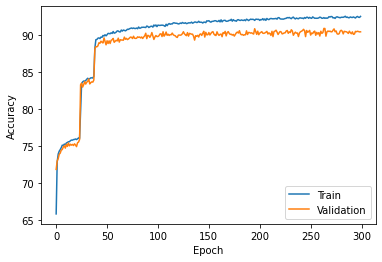

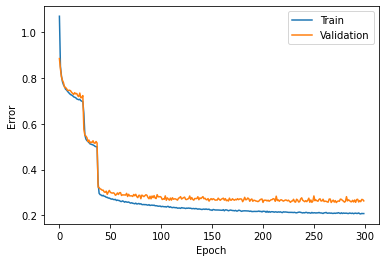

In [59]:
plt.figure()
plt.plot(train_acc,label="Train")
plt.plot(val_acc,label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_err,label="Train")
plt.plot(val_err,label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()
plt.show()

In [60]:
print("Final Train Accuracy: ", train_acc[-1], "%")
print("Final Validation Accuracy: ", val_acc[-1],"%")

print("final loss train , ", train_err[-1])
print("final loss val , ", val_err[-1])

Final Train Accuracy:  92.546 %
Final Validation Accuracy:  90.45904590459045 %
final loss train ,  0.20743333864623628
final loss val ,  0.262752561629573
